<a href="https://colab.research.google.com/github/bluepeach1121/CNN_Model_MNIST/blob/main/customDataSets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

check out pytorch domain library

# 04. custom datasets.
how do you get your own data into Pytorch?

In [146]:
## 0. Importing Pytorch and setting up device-agnostic code

In [147]:
import torch
from torch import nn

#note: just update your pytorch regularly

In [148]:
#setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [149]:
import torch
torch.cuda.is_available()

False

## 1. Get data

our dataset is a subset of the food101 dataset but our dataset has 3 classes (instead of 101 in the food101 dataset). our dataset only has 10% of the food101 dataset

In [150]:
import requests
import zipfile
from pathlib import Path as path

#setup path to a data folder
data_path = path('data/')
image_path = data_path / 'pizza_steak_sushi'

#if the image folder doesnt exist, download it and prepare it....
if image_path.is_dir():
    print(f'{image_path} directory already exists... skipping download')
else:
    print(f'{image_path} doesnt exist, creating one....')
    image_path.mkdir(parents=True, exist_ok=True)

#download pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('downloading pizza, steak and sushi data...')
    f.write(request.content)

#unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('unzipping pizza, steak and sushi data....')
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
downloading pizza, steak and sushi data...
unzipping pizza, steak and sushi data....


## 2. data preparation and data exploration

In [151]:
import os
def walk_through_dir(dir_path):
    """ walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')


In [152]:
walk_through_dir(image_path)

there are 2 directories and 0 images in data/pizza_steak_sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/test
there are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
there are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
there are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
there are 3 directories and 0 images in data/pizza_steak_sushi/train
there are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
there are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
there are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [153]:
# setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# 2.1 visualizing an image

lets write some code to:
1. get all of the image paths
2. pick a random image path using python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. since we're working with images, lets open the image with python's PIL
5. we'll then show the image and print metadata

random image path is: data/pizza_steak_sushi/test/pizza/2019408.jpg
image class: pizza
image size: (512, 512), width is 512, height is 512


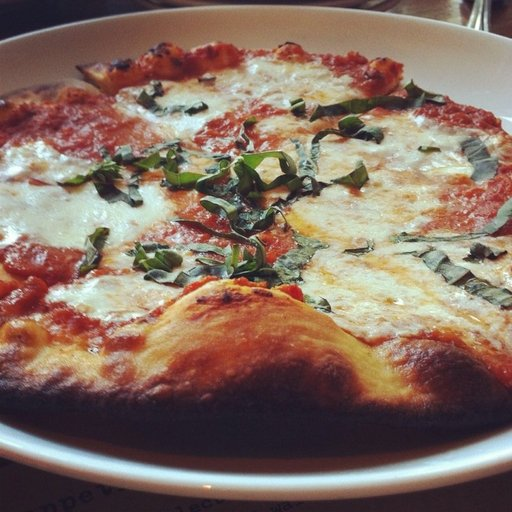

In [154]:
import random
from PIL import Image

# set seed
random.seed(42)

#1. get all the image  paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

#2. pick a random image path
random_image_path = random.choice(image_path_list)

#3. get image class from the path name (the image class is the name of the directory where the image is stored.)
image_class = random_image_path.parent.stem

#4. open image
img = Image.open(random_image_path)

#5. print metadata
print(f'random image path is: {random_image_path}')
print(f'image class: {image_class}')
print(f'image size: {img.size}, width is {img.size[0]}, height is {img.size[1]}')
img


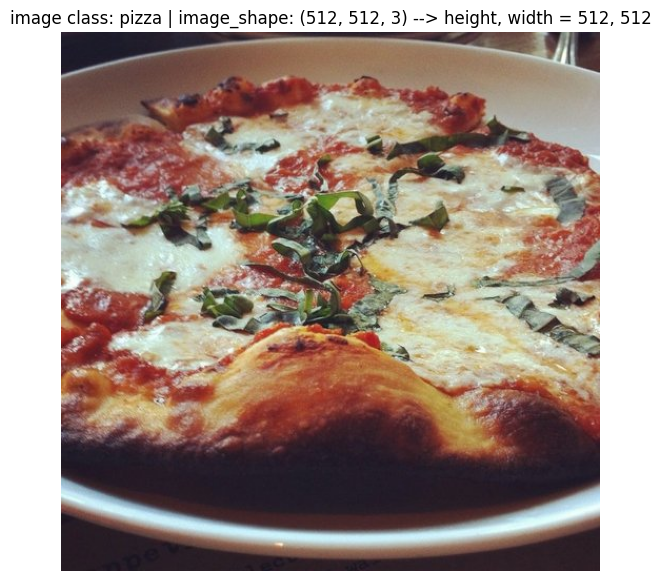

In [155]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_as_array = np.asarray(img)

#plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'image class: {image_class} | image_shape: {img_as_array.shape} --> height, width = {img.size[1]}, {img.size[0]}')
plt.axis('off');

array([[[48, 37, 51],
        [48, 37, 51],
        [49, 38, 52],
        ...,
        [56, 43, 52],
        [60, 45, 52],
        [63, 48, 55]],

       [[47, 36, 50],
        [47, 36, 50],
        [48, 37, 51],
        ...,
        [56, 43, 52],
        [61, 46, 53],
        [63, 48, 55]],

       [[43, 35, 50],
        [43, 35, 50],
        [43, 35, 50],
        ...,
        [60, 45, 52],
        [63, 46, 54],
        [65, 48, 56]],

       ...,

       [[37, 27, 35],
        [37, 27, 35],
        [37, 27, 35],
        ...,
        [45, 30, 37],
        [45, 30, 37],
        [43, 28, 35]],

       [[39, 29, 37],
        [38, 28, 36],
        [38, 28, 36],
        ...,
        [46, 31, 38],
        [46, 31, 38],
        [44, 29, 36]],

       [[40, 30, 38],
        [39, 29, 37],
        [38, 28, 36],
        ...,
        [47, 32, 39],
        [47, 32, 39],
        [45, 30, 37]]], dtype=uint8)
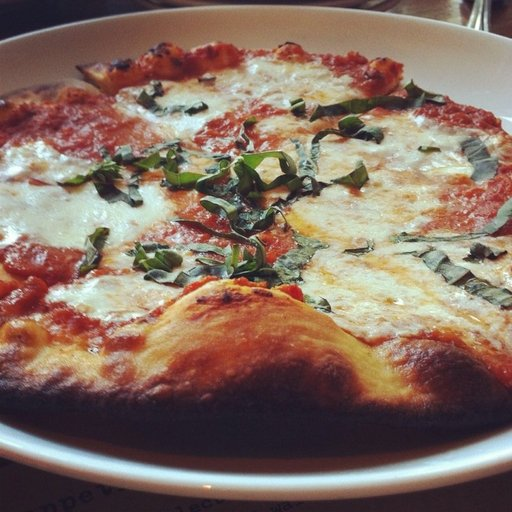

In [156]:
img_as_array

## 3. transforming data.

1. turn your data into tensors
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `Dataloader`.


In [157]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 transforming with `torchvision.transforms`

transforms helps to get the image ready for use with a ML model

In [158]:
# write a transform for image
data_transform = transforms.Compose([
    #resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image into a torch tensor
    transforms.ToTensor()
])

In [159]:
data_transform(img).shape

torch.Size([3, 64, 64])

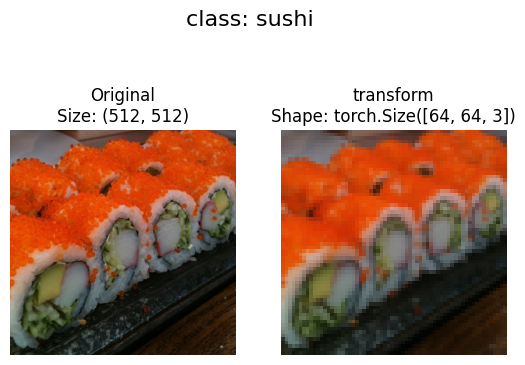

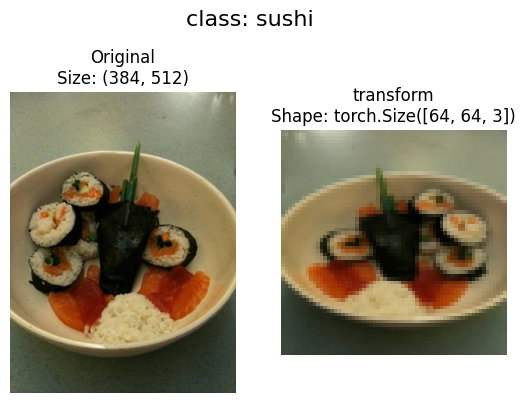

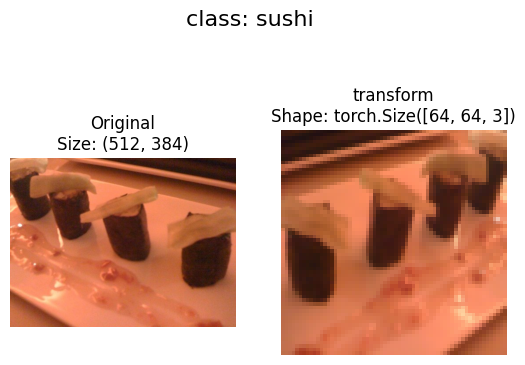

In [160]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    selects random images from a path of images and loads/transforms them then
    plots the original vs the transformed version
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=3)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis('off')

            #transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'transform\nShape: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)



## 4. option 1: loading image data using `ImageFolder`

we can load image classification data using using `torchvision.datasets.ImageFolder`

In [161]:
# use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) #3 a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [162]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [163]:
# get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [164]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [165]:
len(train_data), len(test_data)

(225, 75)

In [166]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [167]:
# index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'image tensor: \n {img}')
print(f'image shape: {img.shape}')
print(f'image label: {label}')
print(f'image datatype: {img.dtype}')
print(f'label datatype: {type(label)}')

image tensor: 
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.

original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

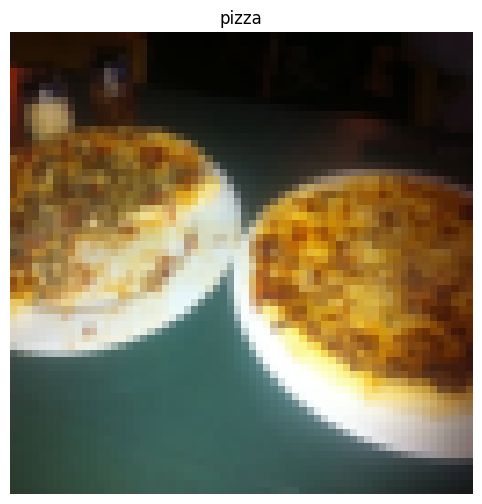

In [168]:
# rearrange the order of dimension
img_permute = img.permute(1, 2, 0)

#print out different shapes
print(f'original shape: {img.shape} -> [color_channels, height, width]')
print(f'image permute: {img_permute.shape} -> [height, width, color_channels]')

#plot the image
plt.figure(figsize=(12, 6))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label])

# 4.1 turn loaded image into `dataloader`

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [169]:
import os
os.cpu_count()

2

In [170]:
# turn train and test datasets into dataloader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size= BATCH_SIZE,
                              shuffle= True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a26ad6888b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a26ad68b640>)

In [171]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [172]:
img, label =next(iter(train_dataloader))

print(f'image shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'label shape: {label.shape}')

image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
label shape: torch.Size([32])


## 5. option 2: loading Image data with a Custom `Dataset`

1. want to be able to load images from a file
2. want to be able to get class names from the Dataset
3. want to be able to get classes as dictionary from the Dataset

pros:
* can create a `Dataset` out of almost anything
* not limited to pytorch pre-built `Dataset` function

cons:
* it doesnt mean it would automatically work......
* More code ---->>> More errors

In [173]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [174]:
# instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 creating a helper function to get class names
we want a function to:

1. Get the class names using `os.scandir()` to traverse a target a target directory.
2. raise an error is the class names arent found
3. turn the class names into a dict and a list and return them.

In [175]:
#setup path for target directory
target_directory = train_dir
print('Target dir: {target_directory}')

# get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: {target_directory}


['pizza', 'steak', 'sushi']

In [176]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]

In [177]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    find the class folder names in a target dictionary
    """
    # 1. get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    #2. raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f'couldnt find any classes in {directory}.... please check file structure')

    #3. create a dicttionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [178]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 create a custom `Dataset` to replicate `ImageFolder`

to create our own custom data, we want to:

1. subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'll like to get data from) as well as a trasform if we'd like to transform our data.
3. create several attributes:
 * paths --> paths of our images
 * transform --> the trandform we'd like to use
 * classes --> a list of the target classes
 * class_to_idx --> a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image.
5. overwrite the `__len()__` method to return the length of our dataset
6. overwrite the `__getitem()__` method to return a given sample when passed an index.


In [179]:
#write a custom dataset class
from torch.utils.data import dataset

#1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    #2. initialize our custom dataset
    def __init__(self,
                 targ_dir: str,
                 transform=None):
        # 3. create class attribute
        # get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        #setup transform
        self.transform = transform
        # create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """
        opens an image via a path and returns it
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. overwrite __len__() mehod
    def __len__(self) -> int:
        """
        returns the total number of samples.
        """
        return len(self.paths)

    # 6. overwrite __getitem__() method to particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        returns one sample of data, data and label (X, y)
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx #returs untransformed images and label

In [180]:
# create a transform
from torchvision import transforms
train_transforms =transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [181]:
#test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                               transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                              transform=test_transforms)

In [182]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a26ada5e200>,
 <__main__.ImageFolderCustom at 0x7a26ada5c820>)

In [183]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [184]:
len(train_data)

225

In [185]:
len(train_data_custom)

225

In [186]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [187]:
# check for equality b-tween original Imagefolder Dataset and IageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 create a function to display random images
1. take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. to prevent the display getting out of hand, lets cap the number of images at 10.
3. set the random seed for reproducability
4. get a list of random sample indexes from the target dataset.
5. set a matplotlib plot.
6. loop thorugh the random sample images and plot them with matplotlib.
7. make sure the dimensions of our images line up with matplotlib (HWC)

In [188]:
#create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    #2. adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f'for display purposes, n shouldnt be larger than 10')

    #3. set the seed
    if seed:
        random.seed(seed)

    #4. get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    #5. setup plot
    plt.figure(figsize=(16, 8))


    #6. loop through indexes and plot them with plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        #7. adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

        #plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f'classes: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adjust.shape}'
        plt.title(title)


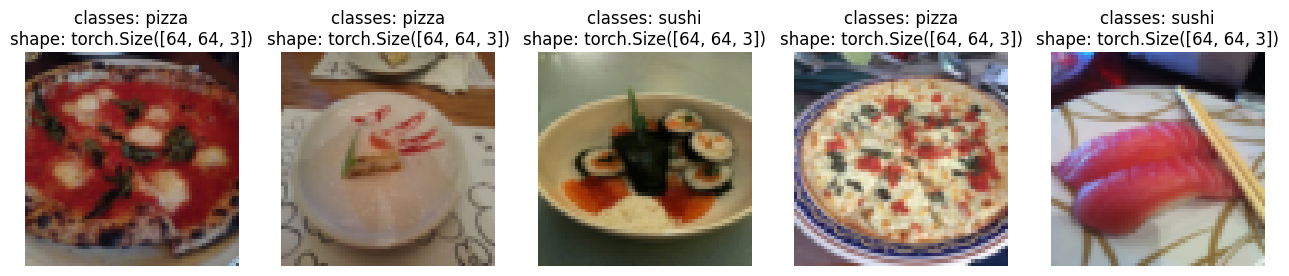

In [189]:
#display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

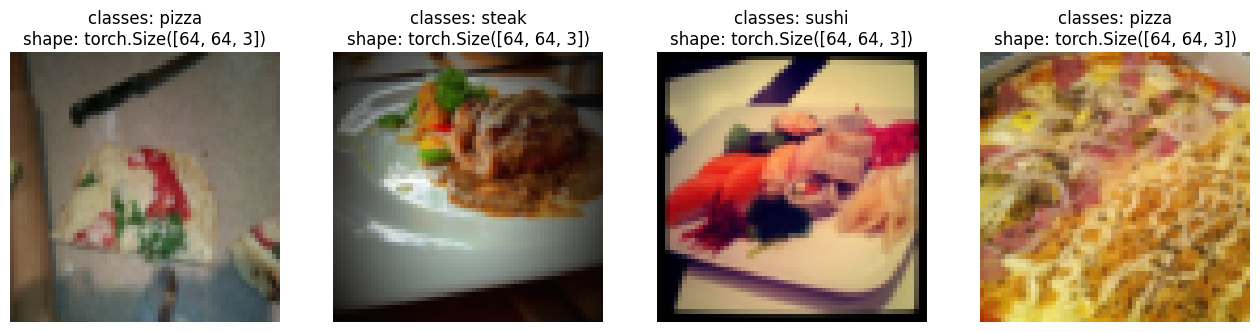

In [190]:
# diplay random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=4,
                      classes=class_names,
                      seed=None)

### 5.4 turn custom loaded images into `DataLoader`s

In [191]:
import os
os.cpu_count

<function posix.cpu_count()>

In [192]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a26ada43070>,
 <torch.utils.data.dataloader.DataLoader at 0x7a26b679fb50>)

In [193]:
# get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

#print out the image
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

##6. other forms of data augmentation

Data augmentation is the process of artificially generating new data from existing data, primarily to train new machine learning (ML) models.

In [194]:
# lets look at trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [195]:
#get all the image path.
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1742201.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/343036.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/46797.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg')]

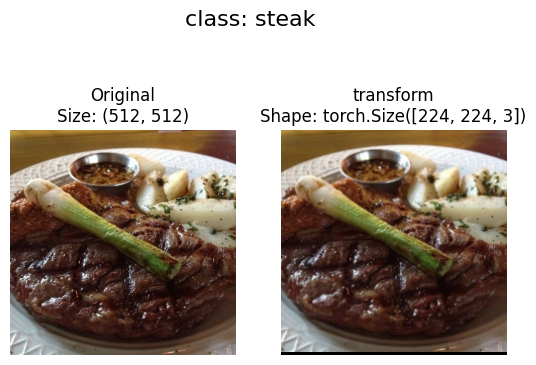

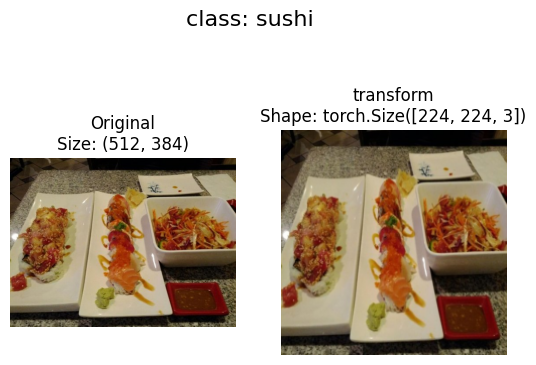

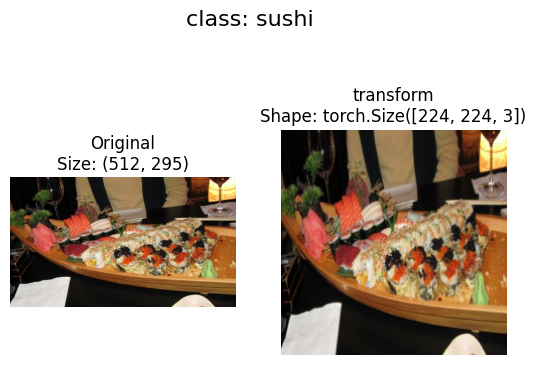

In [196]:
# plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 creating transforms and loading data for model 0


In [197]:
#create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [243]:
#1. load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform = simple_transform)

#2. turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader
#setup the batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

#create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle= True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle = False,
                                    num_workers=NUM_WORKERS)

In [244]:
NUM_WORKERS

2

### 7.2 create TinyVGG model class

In [245]:
class TinyVGG(nn.Module):
    """
    model architecture copying TinyVGG from CNN explainer
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:

        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                    out_channels = hidden_units,
                    kernel_size = 3,
                    stride = 1,
                    padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                    out_channels= hidden_units,
                    kernel_size=3,
                    stride= 1,
                    padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2,
                        padding=1) # default stride values is same as kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                    out_channels = hidden_units,
                    kernel_size = 3,
                    stride = 1,
                    padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                    out_channels= hidden_units,
                    kernel_size=3,
                    stride= 1,
                    padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        stride=2,
                        padding=1) # default stride values is same as kernel size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units * 289,
                    out_features=output_shape)
        )

    def forward(self, x):
        #print(x.shape) # commented out after testing
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        #return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [246]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10, #
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2890, out_features=3, bias=True)
  )
)

### 7.3 try a forward pass on a single image (to test the model)

In [247]:
#get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [248]:
device

device(type='cpu')

In [249]:
#try a forward pass
model_0(image_batch.to(device))

tensor([[ 0.0386, -0.0671,  0.0317],
        [ 0.0362, -0.0703,  0.0334],
        [ 0.0403, -0.0688,  0.0300],
        [ 0.0354, -0.0657,  0.0299],
        [ 0.0424, -0.0704,  0.0293],
        [ 0.0408, -0.0725,  0.0340],
        [ 0.0383, -0.0687,  0.0325],
        [ 0.0435, -0.0745,  0.0287],
        [ 0.0372, -0.0690,  0.0296],
        [ 0.0334, -0.0646,  0.0321],
        [ 0.0401, -0.0678,  0.0308],
        [ 0.0362, -0.0667,  0.0348],
        [ 0.0412, -0.0692,  0.0300],
        [ 0.0377, -0.0661,  0.0306],
        [ 0.0420, -0.0724,  0.0271],
        [ 0.0377, -0.0698,  0.0302],
        [ 0.0372, -0.0662,  0.0317],
        [ 0.0371, -0.0633,  0.0324],
        [ 0.0382, -0.0717,  0.0326],
        [ 0.0418, -0.0693,  0.0319],
        [ 0.0379, -0.0669,  0.0321],
        [ 0.0365, -0.0660,  0.0317],
        [ 0.0362, -0.0646,  0.0348],
        [ 0.0392, -0.0724,  0.0322],
        [ 0.0398, -0.0701,  0.0348],
        [ 0.0425, -0.0702,  0.0315],
        [ 0.0427, -0.0697,  0.0302],
 

### 7.4 use `torchinfo` to get an idea of the shapes of the model

In [250]:
# install torchinfo, import if it's available
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[32, 3, 64, 64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 33, 33]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          280
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 10, 64, 64]          910
│    └─ReLU: 2-4                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 10, 33, 33]          --
├─Sequential: 1-2                        [32, 10, 17, 17]          --
│    └─Conv2d: 2-6                       [32, 10, 33, 33]          910
│    └─ReLU: 2-7                         [32, 10, 33, 33]          --
│    └─Conv2d: 2-8                       [32, 10, 33, 33]          910
│    └─ReLU: 2-9                         [32, 10, 33, 33]          --
│    └─MaxPool2d: 2-10                   [32, 10, 17, 17]          --
├─Sequentia

## 7.5 create train and test loops functions

* `train_step()` -- takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` -- takes in a model and dataloader and evaluates the model on the dataloader.

In [252]:
# create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # put the model in train mode
    model.train()

    #setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    #loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to the target device
        X, y = X.to(device), y.to(device)

        #1. forward pass
        y_pred = model(X) # output model logits

        #2. calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #3. optimizer zero grad
        optimizer.zero_grad()

        #4. loss backwards
        loss.backward()

        #5. optimizer step
        optimizer.step()

        # calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    # adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [254]:
# create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    #put model in eval mode
    model.eval()

    #setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    #turn on inference mode
    with torch.inference_mode():
        #loop through  dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            #send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            test_pred_logits = model(X)

            #2. calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            #calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # adjust metrics metrics to get average loss and accuracy  per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc





### 7.6 creating a `train()` function to combine `train_step()` and `test_case()`

In [255]:
from tqdm.auto import tqdm

#1. create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.nn.Module,
          loss_fn:  torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    #2. create an empty result dictionar
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    #3. loop through training and testing steps for a number of epocha
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        #4. print out whats happening
        print(f'epoch: {epoch} | Train_loss: {train_loss:.4f} | train acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test acc: {test_acc:.4f}')

        #5. update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    #6. return the filled results at the end of the epochs
    return results

### 7.7 train and evaluate model 0

In [256]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs
NUM_EPOCHS = 5

#recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

#setup loss fuunction and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

#start the timer
from timeit import default_timer as timer
start_time = timer()

# train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_data_simple,
                        test_dataloader = test_data_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

#end the timer and print out how long it took
end_time = timer()
print(f'total trainin time: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'int' object has no attribute 'to'